# Data Science for Business Users

## Natural Language Processing - Part 2 - Fine-Tune Text Classification Model (i.e., Text Categorization)

##### &emsp;Author:&emsp;&emsp;Mediumworx Analytics
##### &emsp;Date:&emsp;&emsp;&emsp;February 10, 2019
##### &emsp;Version:&emsp;&emsp;0.1
##### &emsp;Revisions:&emsp;
* 0.1. Initial version

_This tutorial was created to democratize data science for business users (i.e., minimize usage of advanced mathematics topics) and alleviate personal frustration we have experienced on following tutorials and struggling to apply that same tutorial for our needs. Considering this, our mission is as follows:_
* _Provide practical application of data science tasks with minimal usage of advanced mathematical topics_
* _Only use a full set of data, which are similar to data we see in business environment and that are publicly available in a tutorial, instead of using simple data or snippets of data used by many tutorials_
* _Clearly state the prerequisites at beginning of the tutorial.  We will try to provide additional information on those prerequisites_
* _Provide both written tutorial and video tutorial on each topic to ensure all steps are easy to follow and clearly illustrated_

### 1. Description

This is multi-part series on natural language processing, using one of the most widely used data science tool - Python. Natural Language Processing (NLP) is concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

Natural Language Processing Series consists of:
* Part 1 - Develop Text Classification Model
* __Part 2 - Fine-Tune Text Classification Model__
* Part 3 - Deploy Text Classification Model

### 2. Prerequisites

Following are prerequisite knowledge for this tutorial:
    - [x] Completed Part 1 - Develop Text Classification Model
    - [x] Basic knowledge Python (You really do not need to be expert in python to use python for data science tasks. Many data scientists supplement their basic knowledge of python with google :-) to complete their tasks. We will provide a tutorial soon...
    - [x] Basic knowledge installing Python packages (Good news is that Anaconda simplifies this for you somewhat, but they only have limited selection of packages you may need - e.g., pmdarima, which is used in this tutorial cannot be installed using this method). We will provide a tutorial soon...
    - [x] Basic knowledge Jupyter Notebook/Lab (Good news is that Jupyter Notebook/Lab is easy to use and learn). We will provide a tutorial soon...
    - [x] Basic knowledge Pandas (Pandas is data analysis tools for the Python programming language. This is one of the tool where more you know will make your job easier and there is always google :-). We will provide a tutorial soon...
    - [x] Basic knowledge statistical data visualization tool, such as matplotlib, seaborn, bokeh, or plotly (These are data visualization tool for the Python programming language. These are a set of the tool where more you know will make your job easier and there is always google :-). We will provide a tutorial soon...

### 3. Steps

Please follow the step by step instructions, which is divided into 10 major steps as shown below:


* Import Python Packages
* Import Data
* Iterate Model: Iterate through different combination of fastText training options
    - Develop Iteration
    - Test Iteration 
    - Predict 'Rating Star' Iteration
    - Validate Iteration

#### 3.1. Import Python Packages

In [1]:
import pandas as pd
import string
import os
import gc
import numpy as np
import nltk
import platform
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
print('python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('NumPy: ', np.__version__)
print('nltk: ', nltk.__version__)
print('platform: ', platform.__version__)
print('seaborn: ', sns.__version__)

python:  3.7.1
pandas:  0.23.4
NumPy:  1.15.4
nltk:  3.4
platform:  1.0.8
seaborn:  0.9.0


Very short explanation of python packages:
* pandas: data analysis tool
* numpy: scientific computing tool
* nltk: natural language toolkit
* seasborn: python charting tool

#### 3.2. Declare Confusion Matrix function

In [3]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### 3.3. Import Data

We will need to import test data so we can create a confusion matrix.

In [4]:
test_review_data = pd.read_pickle('data/yelp_review_data_prepped_test.pkl')

#### 3.4. Iterate Model

The following are optional parameters to improve our text classification model:

    -lr                 learning rate [0.05]
    -lrUpdateRate       change the rate of updates for the learning rate [100]
    -dim                size of word vectors [100]
    -ws                 size of the context window [5]
    -epoch              number of epochs [5]
    -neg                number of negatives sampled [5]
    -loss               loss function {ns, hs, softmax} [ns]
    -thread             number of threads [12]
    -pretrainedVectors  pretrained word vectors for supervised learning []
    -saveOutput         whether output params should be saved [0]

Follow these steps to develop/train model:
1. In terminal window, navigate to where your fastText is installed.  For myself, it is /home/sungkim/fastText
2. fastText command we will be using is 'fasttext supervised -input training_file -output model_name'
3. Our training file name is 'train_review_data.txt'
4. Our model name is 'yelp_model_v1'.  We like to version our models so we can come back to it.
5. With that in mind, enter following command in your terminal.  My data (i.e., text files) are located in d:\Mediumworx\analytics\Text_Classification\data directory, hence the long path.

##### 3.3.1. Model Baseline

The baseline (default option) produced following precision and recall:
* P@1     0.687 
* R@1     0.687

##### 3.3.2. Iteration 2

For iteration 2, we would be using different loss function, where the default is ns:
* ns: Skipgram negative sampling or SGNS
* __hs: Skipgram Hierarchical softmax__
* softmax: well, softmax

This iteration produces following precision and recall:
* P@1     0.683 
* R@1     0.683

Confusion Matrix

In [5]:
test_predict_data_v2 = pd.read_csv('data/test_predict_data_v2.txt', delimiter=r"\s+", header=None)
test_predict_data_v2.columns = ['predict', 'predict-prob']

In [6]:
test_predict_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [7]:
cm_v2 = confusion_matrix(test_review_data['stars'], test_predict_data_v2['predict'])
cm_v2

array([[167080,  18496,   6450,   2258,   6646],
       [ 33614,  36127,  27478,   6327,   4598],
       [ 10069,  16935,  63295,  46408,  11407],
       [  3728,   3124,  29172, 151427, 106700],
       [  4767,   1269,   7238,  77690, 494877]])

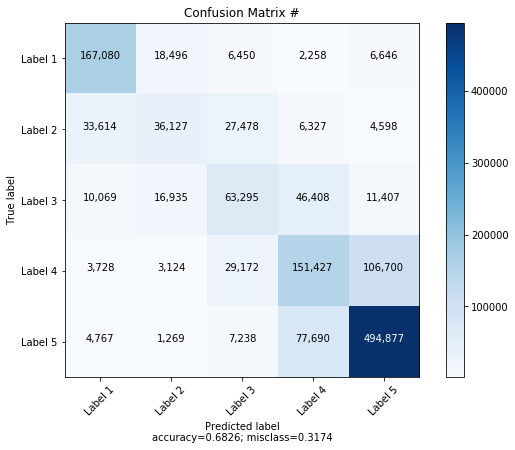

In [8]:
plot_confusion_matrix(cm=cm_v2, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

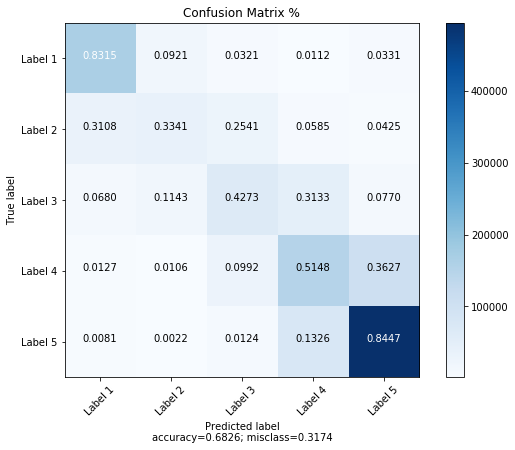

In [9]:
plot_confusion_matrix(cm=cm_v2, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.3. Iteration 3

For iteration 3, we would be using different loss function, where the default is ns:
* ns: Skipgram negative sampling or SGNS
* hs: Skipgram Hierarchical softmax
* __softmax: well, softmax__

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [10]:
test_predict_data_v3 = pd.read_csv('data/test_predict_data_v3.txt', delimiter=r"\s+", header=None)
test_predict_data_v3.columns = ['predict', 'predict-prob']

In [11]:
test_predict_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [12]:
cm_v3 = confusion_matrix(test_review_data['stars'], test_predict_data_v3['predict'])
cm_v3

array([[171055,  16978,   5298,   2141,   5458],
       [ 36405,  35239,  25179,   6524,   4797],
       [ 11223,  17156,  60252,  45984,  13499],
       [  4027,   3113,  25649, 146166, 115196],
       [  5042,   1214,   5079,  68005, 506501]])

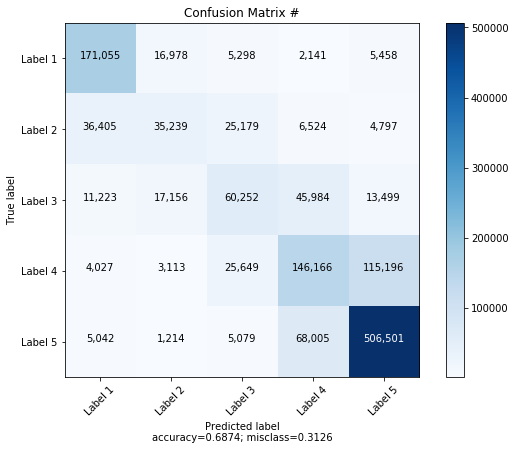

In [13]:
plot_confusion_matrix(cm=cm_v3, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

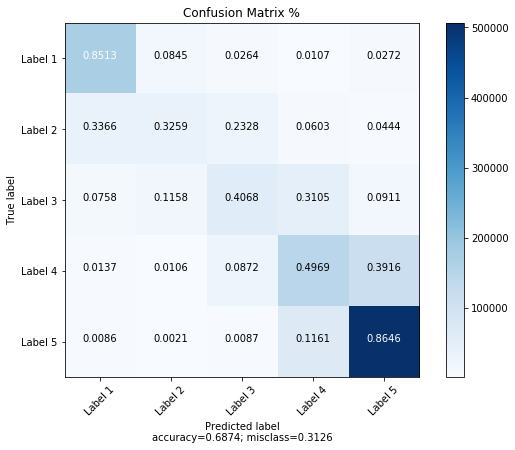

In [14]:
plot_confusion_matrix(cm=cm_v3, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.4. Iteration 4

For iteration 4, we would be using different learning rate, where the default is 0.05:
* __0.10__
* 0.20

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [15]:
test_predict_data_v4 = pd.read_csv('data/test_predict_data_v4.txt', delimiter=r"\s+", header=None)
test_predict_data_v4.columns = ['predict', 'predict-prob']

In [16]:
test_predict_data_v4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [17]:
cm_v4 = confusion_matrix(test_review_data['stars'], test_predict_data_v4['predict'])
cm_v4

array([[171298,  16856,   5169,   2180,   5427],
       [ 36670,  35248,  24753,   6678,   4795],
       [ 11321,  17290,  59451,  46500,  13552],
       [  4061,   3144,  25049, 146190, 115707],
       [  5094,   1211,   4960,  67720, 506856]])

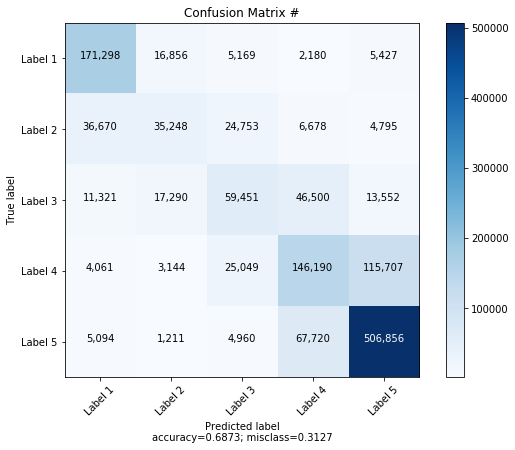

In [18]:
plot_confusion_matrix(cm=cm_v4, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

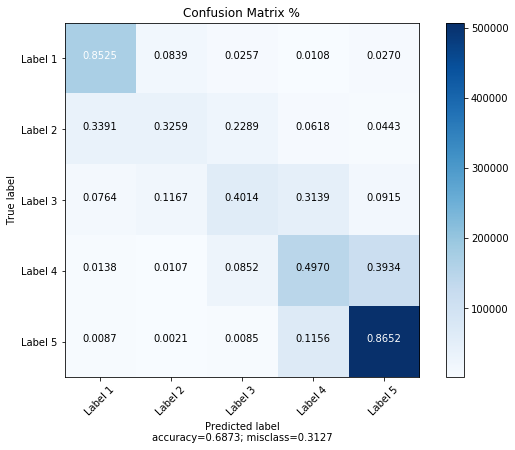

In [19]:
plot_confusion_matrix(cm=cm_v4, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.5. Iteration 5

For iteration 5, we would be using different learning rate, where the default is 0.05:
* 0.10
* __0.20__

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [20]:
test_predict_data_v5 = pd.read_csv('data/test_predict_data_v5.txt', delimiter=r"\s+", header=None)
test_predict_data_v5.columns = ['predict', 'predict-prob']

In [21]:
test_predict_data_v5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [22]:
cm_v5 = confusion_matrix(test_review_data['stars'], test_predict_data_v5['predict'])
cm_v5

array([[170812,  17338,   5343,   2073,   5364],
       [ 36137,  35541,  25334,   6389,   4743],
       [ 11131,  17279,  60790,  45497,  13417],
       [  4020,   3149,  26187, 145853, 114942],
       [  5082,   1234,   5177,  68055, 506293]])

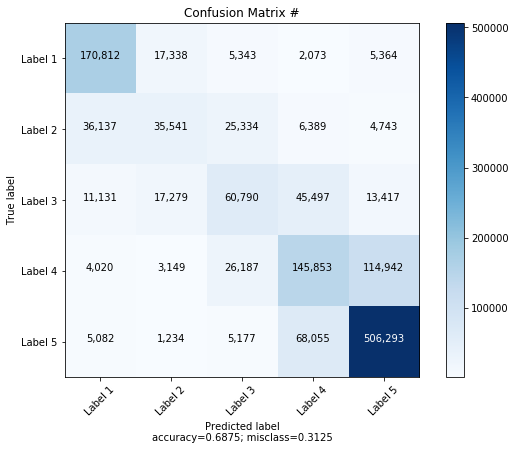

In [23]:
plot_confusion_matrix(cm=cm_v5, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

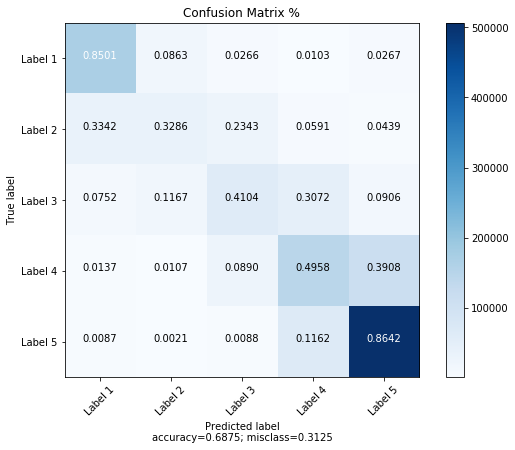

In [24]:
plot_confusion_matrix(cm=cm_v5, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.6. Iteration 6

For iteration 6, we would be using different learning update rate, where the default is 100:
* __200__
* 300

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [26]:
test_predict_data_v6 = pd.read_csv('data/test_predict_data_v6.txt', delimiter=r"\s+", header=None)
test_predict_data_v6.columns = ['predict', 'predict-prob']

In [31]:
test_predict_data_v6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [28]:
cm_v6 = confusion_matrix(test_review_data['stars'], test_predict_data_v6['predict'])
cm_v6

array([[171184,  17038,   5251,   2138,   5319],
       [ 36538,  35293,  25038,   6594,   4681],
       [ 11278,  17244,  59907,  46417,  13268],
       [  4089,   3137,  25449, 147131, 114345],
       [  5146,   1236,   5101,  68943, 505415]])

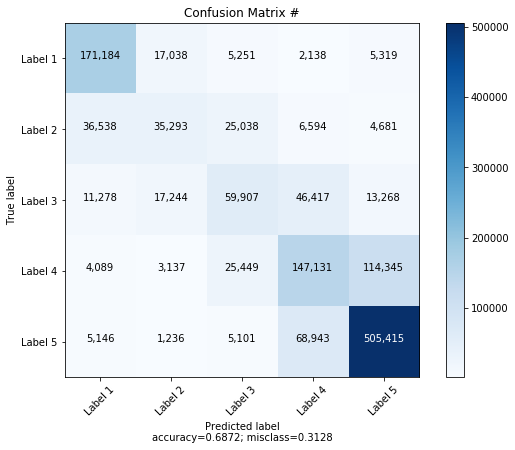

In [29]:
plot_confusion_matrix(cm=cm_v6, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

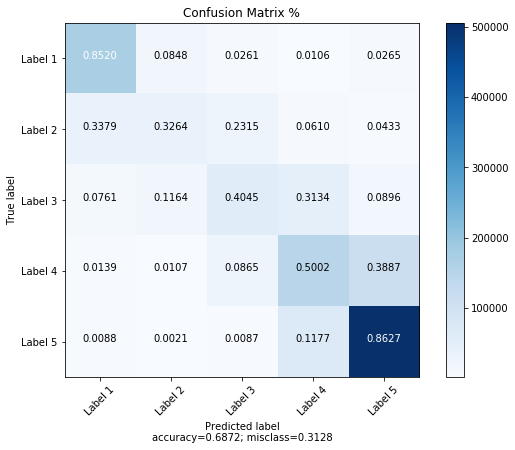

In [30]:
plot_confusion_matrix(cm=cm_v6, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.7. Iteration 7

For iteration 7, we would be using different epoch, where the default is 5:
* __10__
* 20
* 30

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [32]:
test_predict_data_v7 = pd.read_csv('data/test_predict_data_v7.txt', delimiter=r"\s+", header=None)
test_predict_data_v7.columns = ['predict', 'predict-prob']

In [33]:
test_predict_data_v7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [34]:
cm_v7 = confusion_matrix(test_review_data['stars'], test_predict_data_v7['predict'])
cm_v7

array([[170738,  17484,   5262,   2111,   5335],
       [ 36244,  36013,  24702,   6503,   4682],
       [ 11159,  17686,  60161,  45820,  13288],
       [  3984,   3296,  25946, 146236, 114689],
       [  5000,   1277,   5168,  68354, 506042]])

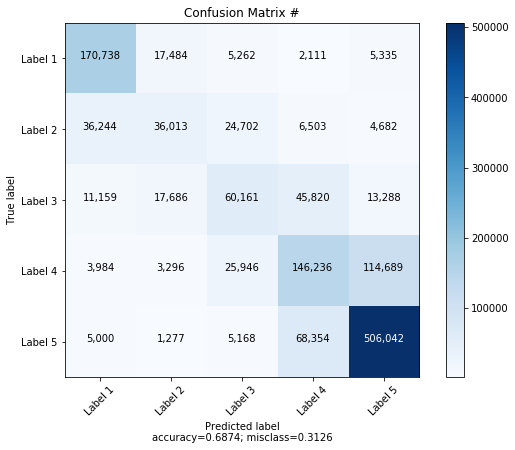

In [35]:
plot_confusion_matrix(cm=cm_v7, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

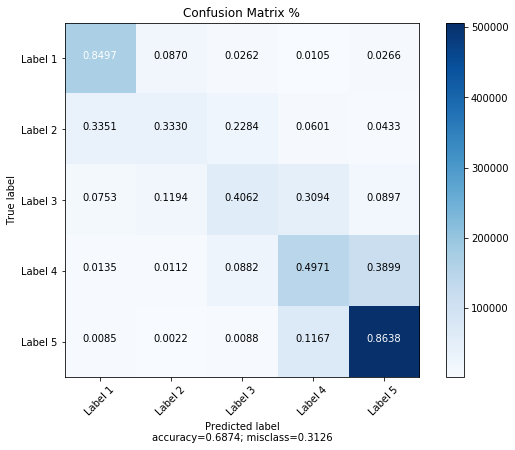

In [36]:
plot_confusion_matrix(cm=cm_v7, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.8. Iteration 8

For iteration 8, we would be using different epoch, where the default is 5:
* 10
* __20__
* 30

This iteration produces following precision and recall:
* P@1     0.687 
* R@1     0.687

Confusion Matrix

In [37]:
test_predict_data_v8 = pd.read_csv('data/test_predict_data_v8.txt', delimiter=r"\s+", header=None)
test_predict_data_v8.columns = ['predict', 'predict-prob']

In [38]:
test_predict_data_v8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [39]:
cm_v8 = confusion_matrix(test_review_data['stars'], test_predict_data_v8['predict'])
cm_v8

array([[170166,  17904,   5451,   2178,   5231],
       [ 35807,  36249,  25022,   6523,   4543],
       [ 11071,  17916,  60518,  45540,  13069],
       [  3929,   3463,  26551, 146372, 113836],
       [  4978,   1386,   5370,  69299, 504808]])

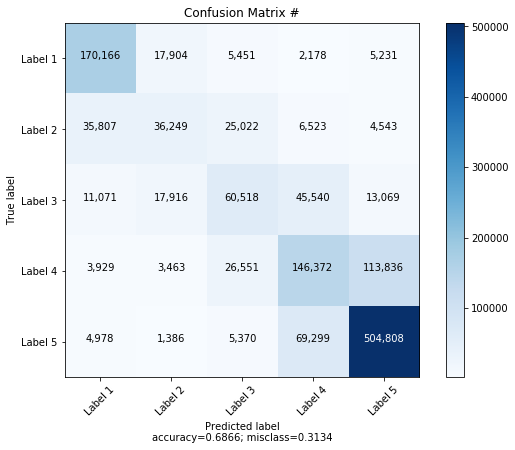

In [40]:
plot_confusion_matrix(cm=cm_v8, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

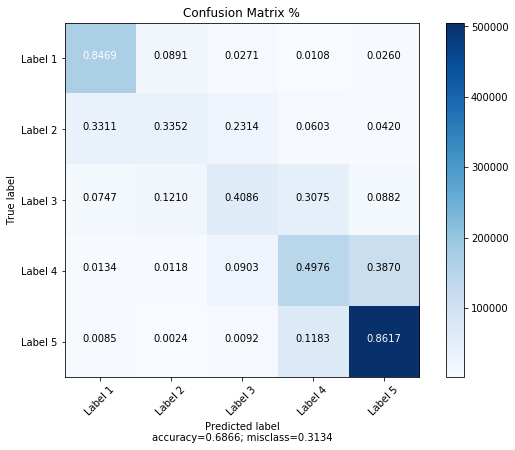

In [41]:
plot_confusion_matrix(cm=cm_v8, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.9. Iteration 9

For iteration 9, we would be using different epoch, where the default is 5:
* 10
* 20
* __30__

This iteration produces following precision and recall:
* P@1     0.685
* R@1     0.685

Confusion Matrix

In [43]:
test_predict_data_v9 = pd.read_csv('data/test_predict_data_v9.txt', delimiter=r"\s+", header=None)
test_predict_data_v9.columns = ['predict', 'predict-prob']

In [44]:
test_predict_data_v9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [45]:
cm_v9 = confusion_matrix(test_review_data['stars'], test_predict_data_v9['predict'])
cm_v9

array([[169487,  18361,   5541,   2252,   5289],
       [ 35604,  36424,  24911,   6657,   4548],
       [ 10957,  18328,  59942,  45717,  13170],
       [  3873,   3639,  26496, 145602, 114541],
       [  4920,   1452,   5465,  69120, 504884]])

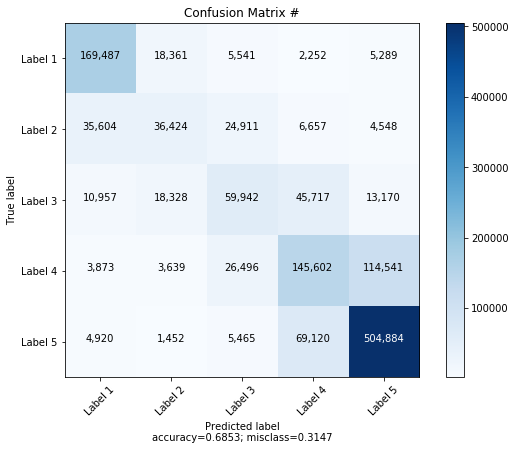

In [46]:
plot_confusion_matrix(cm=cm_v9, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

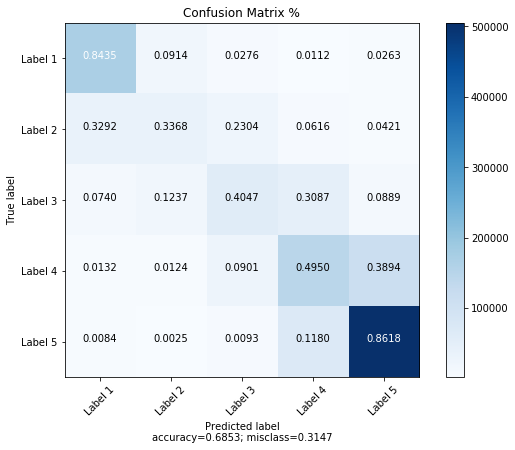

In [47]:
plot_confusion_matrix(cm=cm_v9, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

##### 3.3.10. Iteration 10

For iteration 9, we would be using different wordNgrams, where the default is 1:
* 0
* __2__
* 3
* 4
* 5

This iteration produces following precision and recall:
* P@1     0.648
* R@1     0.648

Confusion Matrix

In [49]:
test_predict_data_v10 = pd.read_csv('data/test_predict_data_v10.txt', delimiter=r"\s+", header=None)
test_predict_data_v10.columns = ['predict', 'predict-prob']

In [50]:
test_predict_data_v10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337180 entries, 0 to 1337179
Data columns (total 2 columns):
predict         1337180 non-null object
predict-prob    1337180 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.4+ MB


In [51]:
cm_v10 = confusion_matrix(test_review_data['stars'], test_predict_data_v10['predict'])
cm_v10

array([[155901,  28766,   8970,   3269,   4024],
       [ 31399,  41507,  25124,   6834,   3280],
       [  9634,  23545,  62150,  40158,  12627],
       [  3065,   6096,  37190, 140892, 106908],
       [  3907,   2759,  11908, 100552, 466715]])

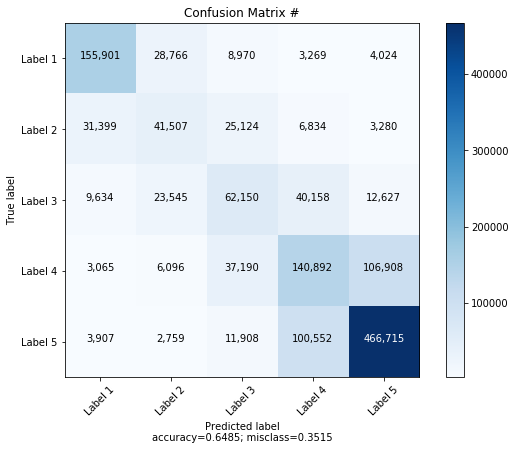

In [52]:
plot_confusion_matrix(cm=cm_v10, normalize=False, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix #")

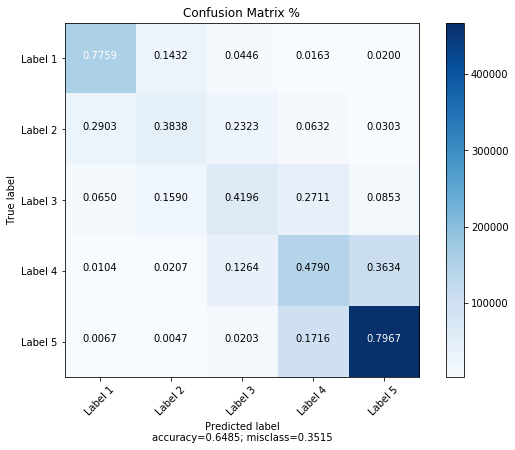

In [53]:
plot_confusion_matrix(cm=cm_v10, normalize=True, target_names = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5'], title = "Confusion Matrix %")

### I hope you have enjoyed this tutorial. If you have any questions or comments, please provide them via Issues feature on GitHub